60000 10000 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 0)


torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


/root/anaconda3/envs/env_cp311_ymz/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/root/anaconda3/envs/env_cp311_ymz/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/root/anaconda3/envs/env_cp311_ymz/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/root/anaconda3/envs/env_cp311_ymz/lib/python3.11/site-packages/I

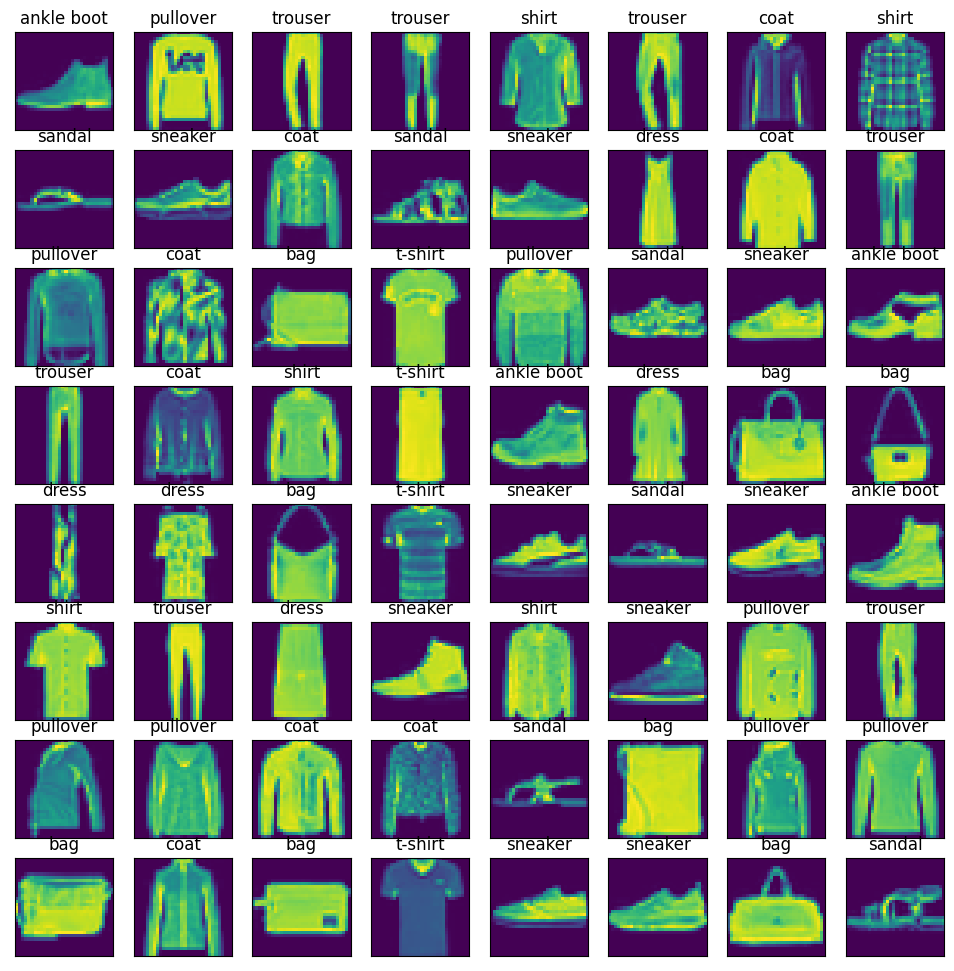

In [5]:
import sys, os
# sys.path.append(__file__)
# sys.path.append(os.path.dirname(__file__))

import time
import torch
import torchvision
from torchvision import transforms
import core


# region dataset
class FashionMNIST(core.DataModule):
    """Fashion-MNIST dataset"""
    def __init__(self,
                 batch_size=64,
                 resize=(28, 28),
                 root="/home/yingmuzhi/_learning/d2l/data"):
        super().__init__()
        self.save_hyperparameters()
        trans = torchvision.transforms.Compose([
            torchvision.transforms.Resize(resize),
            torchvision.transforms.ToTensor(),
        ])
        # dataset
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root,
            train=True,
            transform=trans,
            download=False,
        )
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root,
            train=False,
            transform=trans,
            download=False,
        )
    
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, 
                                           self.batch_size, 
                                           shuffle=train, 
                                           num_workers=self.num_workers)

# transform index to text
@core.add_to_class(FashionMNIST)
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

# visualize data
@core.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    core.show_images(X.squeeze(1), nrows, ncols, titles=labels)

# see dataset
data = FashionMNIST(resize=(32, 32))
print(len(data.train), len(data.val), data.train[2])

# see train dataloader
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

# see val dataloader's visulization
batch = next(iter(data.val_dataloader()))
data.visualize(batch, nrows=8)
pass
# endregion

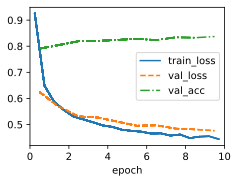

In [2]:
import sys, os
from typing import Iterator

from torch.nn.parameter import Parameter
# sys.path.append(__file__)
# sys.path.append(os.path.dirname(__file__))

import time
import torch
import torchvision
from torchvision import transforms
import core


# region dataset
"""

1. build dataset
"""
class FashionMNIST(core.DataModule):
    """Fashion-MNIST dataset"""
    def __init__(self,
                 batch_size=64,
                 resize=(28, 28),
                 root="/home/yingmuzhi/_learning/d2l/data"):
        super().__init__()
        self.save_hyperparameters()
        trans = torchvision.transforms.Compose([
            torchvision.transforms.Resize(resize),
            torchvision.transforms.ToTensor(),
        ])
        # dataset
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root,
            train=True,
            transform=trans,
            download=False,
        )
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root,
            train=False,
            transform=trans,
            download=False,
        )
    
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, 
                                           self.batch_size, 
                                           shuffle=train, 
                                           num_workers=self.num_workers)

# transform index to text
@core.add_to_class(FashionMNIST)
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

# visualize data
@core.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    core.show_images(X.squeeze(1), nrows, ncols, titles=labels)


"""

2. test
"""
# # see dataset
# data = FashionMNIST(resize=(32, 32))
# print(len(data.train), len(data.val), data.train[2])

# # see train dataloader
# X, y = next(iter(data.train_dataloader()))
# print(X.shape, X.dtype, y.shape, y.dtype)

# # see val dataloader's visulization
# batch = next(iter(data.val_dataloader()))
# data.visualize(batch)
# pass
# endregion


# region model
"""

1. build model
"""
class Classifier(core.ModelModule):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot("loss", self.loss(Y_hat, batch[-1]), train=False)
        self.plot("acc", self.accuracy(Y_hat, batch[-1]), train=False)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)
    
    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions."""
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare

"""

2. softmax
"""
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True) # sum all X_exp's elements
    return X_exp / partition

"""

3. CE loss and build model 2
"""
class SoftmaxRegressionScratch(Classifier):
    def __init__(self, 
                 num_inputs,
                 num_outputs,
                 lr,
                 sigma=0.01) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W) + self.b)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)
    
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()
"""

4. test
"""
# # softmax
# X = torch.rand((2, 5))
# X_prob = softmax(X)
# print(X_prob, X_prob.sum(1))

# # CE loss
# y = torch.tensor([0, 2])    # 指具有两个样本，第一个样本类别0，第二个样本类别2
# y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# y_hat[[0, 1], y]
# print(cross_entropy(y_hat, y))
# pass
# endregion

# region main
data = FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = core.TrainerModule(max_epochs=10)
trainer.fit(model, data)
# endregion